In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# loading keras and FBD experiment...
from keras import backend as K
K.set_floatx('float32')
from helpers import *
from model_conv import *
from experiment_model import *
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm
import sys
import numpy as np
from IPython.display import Image, display

# to show the model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import Model, Input
from keras.layers import Activation

# loading resnet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import decode_predictions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


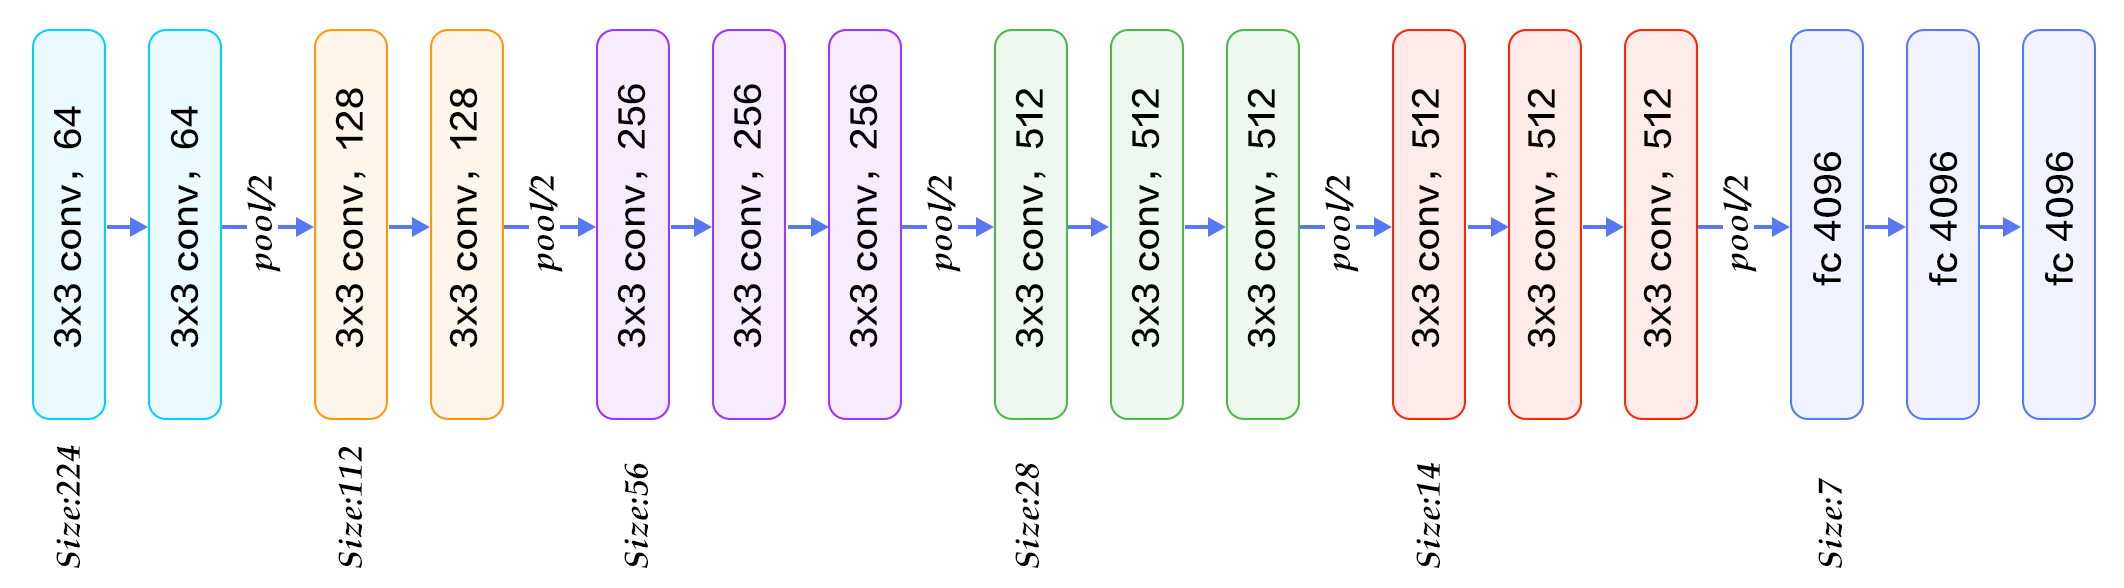

In [25]:
# creating vgg16 model
model = VGG16(weights = 'imagenet')

# replacing max pooling with average
model = pool_max2avg(model)

# removing top softmax activation
model = remove_activation(model, -1)

# replacing ReLU with Softplus(2)
model = replace_relu_with_softplus(model, scaler = 2.0)

# output layer
l = 0

Replaced maxpool to avgpool at layers [2, 5, 9, 13, 17]
Removing activation from layer -1
Applying modifications...


/localhome/volodin/miniconda3/envs/rl/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Replacing ReLU to Softplus(2.00)
Replaced activations {'relu'} on layers [1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17, 20, 21] with softplus
Applying modifications...


In [26]:
# choosing only this output layer
model = cut_and_flatten(model, l)

# making input grayscale
model = grayscale(model)

In [5]:
# inactive
#d = 10
#model_upscale = upscale_from(model_cut, d)

In [27]:
model.layers, model.layers[2].layers

([<keras.engine.input_layer.InputLayer at 0x7f0dde9a7a20>,
  <keras.layers.core.Dense at 0x7f0dde9a71d0>])

In [28]:
#!googleimagesdownload --keywords "Cat,dog" --limit 20

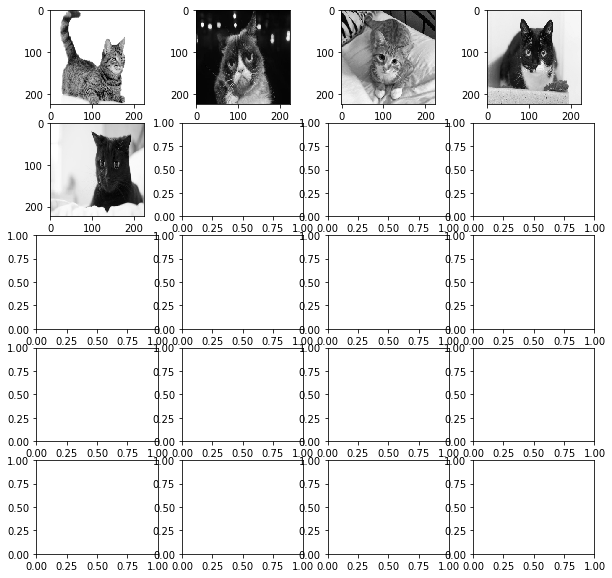

In [29]:
# directory with images
dr = 'downloads/Cat/'

# all images
images = os.listdir(dr)[:5]

# loading the cat image
xs = []
fig, axes = plt.subplots(5, 4, figsize=(10, 10))
axes = axes.flatten()
for i, img in enumerate(images):
    x = load_image(dr + img, axis = axes[i]) / 255.
    xs.append(x)
plt.show()
xs = np.mean(xs, axis = 1)

In [30]:
# making only 10 entries in the red channel column 0 faulty
#rc0 = 10
#x, x_without_first = split_x_rc0(x, rc0 = rc0)

In [31]:
# create a model which adds the rest
#model = merge_with_taken(model, x_without_first, rc0 = rc0)

In [32]:
for x in xs:
    x = np.array([x])
    if l == -1:
        print(decode_predictions(model.predict(x), top=3)[0])
    else:
        print(model.predict(x))

[[118557.04]]
[[30367.484]]
[[84588.5]]
[[96562.766]]
[[102634.23]]


In [33]:
# probability of input failure
p = 0.001

In [34]:
# calculating np
n = np.prod(list(map(int, model.inputs[0].shape[1:])))
n, n * p

(50176, 50.176)

In [35]:
# keeping indices with the largest output probability
top_predictions = 5
to_keep = np.array(np.argsort(-model.predict(xs[0:1]))[0][:top_predictions], dtype = np.int32)

In [36]:
print('Keeping output indices ' + ', '.join([str(t) for t in to_keep]))

Keeping output indices 0


In [37]:
# model with only these indices kept
model = keep_oindices(model, to_keep)

In [38]:
# obtaining experiment from a model
exp = ModelInputCrashExperiment(model, p = p)

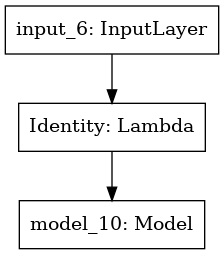

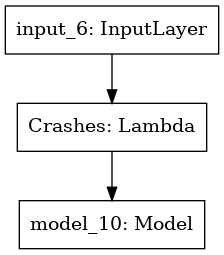

In [39]:
# showing correct/crashing models
display(Image(model_to_dot(exp.model_correct, ).create(prog='dot', format='png'), width = 80))
display(Image(model_to_dot(exp.model_crashing).create(prog='dot', format='png'), width = 80))

In [40]:
# crashing prediction
decode_predictions(predict_kept(exp.model_crashing, x, to_keep), top=3)[0]

[('n01440764', 'tench', 102536.0234375),
 ('n02319095', 'sea_urchin', 0.0),
 ('n02395406', 'hog', 0.0)]

In [41]:
# correct prediction
decode_predictions(predict_kept(exp.model_correct, x, to_keep), top=3)[0]

[('n01440764', 'tench', 102634.2265625),
 ('n02319095', 'sea_urchin', 0.0),
 ('n02395406', 'hog', 0.0)]

In [42]:
# get theoretical error (bound b3)
theoretical = exp.get_bound_b3(np.array(xs))

In [43]:
# get experimental error
experimental = experiment_mean_std(exp, xs, repetitions = 500)

In [44]:
def process(key = 'mean'):
    """ Process data for theory/experiment """
    t, e = theoretical[key], experimental[key]
    print('Shapes', t.shape, e.shape)
    print("Norm delta", np.linalg.norm(t - e) / np.linalg.norm(e))
    for out_dim in range(t.shape[1]):
        plt.scatter(t[:,out_dim], e[:,out_dim])
    plt.xlabel('Theory')
    plt.ylabel('Experiment')
    plt.title('Components: ' + key)
    plt.show()
    
    plt.xlabel('Theory')
    plt.ylabel('Experiment')
    plt.title('Norm: ' + key)
    plt.scatter(np.linalg.norm(t, axis = 1), np.linalg.norm(e, axis = 1))
    plt.show()

Shapes (5, 1) (5, 1)
Norm delta 0.005713518


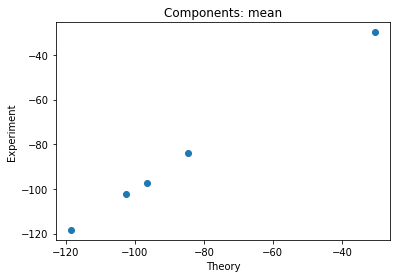

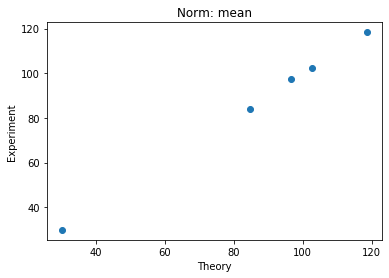

In [45]:
process('mean')

Shapes (5, 1) (5, 1)
Norm delta 0.020138176


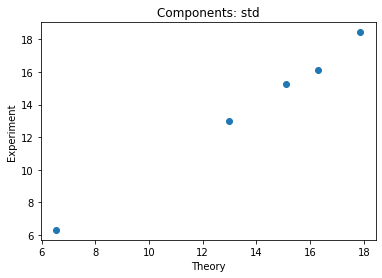

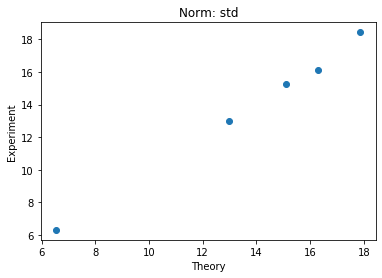

In [46]:
process('std')

Problem: experimental mean is not in line with theory. Variance is much better. Why? Trying various methods (remove top softmax, full image/only some pixels/many images instead of 1/plotting 1st component only/plotting norm difference/grayscale) -- still same result.

A bit better for large p for some reason. The expansion holds for small p, as it's an expansion over p

p 10^-3 grayscale full image 1000, 5000 repetitions bad mean, ~ok variance

In [37]:
# Does the model have any batch norm at input?
# does not seem so
model.layers[2].layers

In [150]:
# why is 5000 repetitions enough for the mean to stabilize? probability is really small, so
# we only cover a tiny subset of all possibilities... plotting mean(repetitions)
# seems to stabilize
x_test = xs[0:1]
def get_dta(reps):
    experimental = experiment_mean_std(exp, x_test, repetitions = reps)
    return experimental['mean'][0][0]
R = [1,2,3] + [int(t) for t in np.linspace(10, 500, 10)]
d = [get_dta(r) for r in tqdm(R)]



  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 17.12it/s]

 46%|████▌     | 6/13 [00:00<00:00,  7.04it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.13it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  2.75it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.05it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  1.63it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.33it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.13it/s]

100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


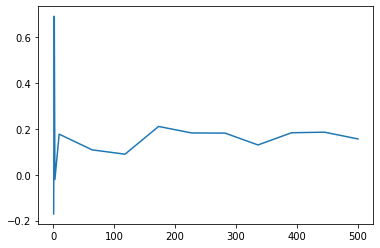

In [151]:
plt.plot(R, d)

In [152]:
# maybe the computation is bad? trying manually
m = exp.model_correct
bound = -p * tf.reduce_sum((tf.multiply(tf.gradients(m.output[:, 0], m.layers[0].output)[0], m.layers[0].output)), axis = [1,2])
sess = get_session()
z = exp.compute_error(x_test, 5000)[0,:,0]

0.15645137
[-0.00863074]


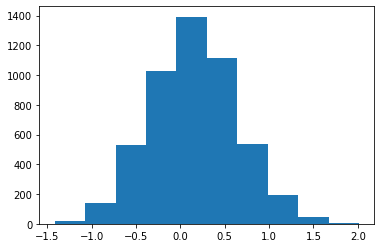

In [195]:
plt.hist(z)
print(np.mean(z))
print(sess.run(bound, {m.input: x_test}))
# why is there such a HUGE difference???

In [236]:
# Trying a simpler model: sum(x) -- must have a trivial result
# E Delta = -px
# Works great

#input_tensor = Input(shape = (224, 224))
model1 = Sequential()
model1.add(InputLayer(input_shape = (224, 224,)))
model1.add(Lambda(lambda x : tf.expand_dims(tf.reduce_sum(x, axis=[1,2]), 1)))

exp1 = ModelInputCrashExperiment(model1, p = 0.001)

# get theoretical error (bound b3)
theoretical = exp1.get_bound_b3(x_test)

# get experimental error
experimental = experiment_mean_std(exp1, x_test, repetitions = 500)

print(theoretical, experimental)

{'mean': array([[-10077.349]], dtype=float32), 'std': array([[1518.844]], dtype=float32)} {'mean': array([[-10129.938]], dtype=float32), 'std': array([[1577.5563]], dtype=float32)}


In [245]:
# trying with a mean: OK
# trying with a sigmoid: OK
# Trying a simpler model with a non-linearity

#input_tensor = Input(shape = (224, 224))
model1 = Sequential()
model1.add(InputLayer(input_shape = (224, 224,)))
model1.add(Lambda(lambda x : tf.expand_dims(tf.sigmoid(tf.reduce_mean(x, axis=[1,2]) / 1000.), 1)))

exp1 = ModelInputCrashExperiment(model1, p = 0.01)

# get theoretical error (bound b3)
theoretical = exp1.get_bound_b3(x_test)

# get experimental error
experimental = experiment_mean_std(exp1, x_test, repetitions = 500)

print(theoretical, experimental)

{'mean': array([[-0.00049707]], dtype=float32), 'std': array([[2.3691084e-05]], dtype=float32)} {'mean': array([[-0.00049775]], dtype=float32), 'std': array([[2.3914967e-05]], dtype=float32)}


In [ ]:
# Trying a simple model with a conv layer

In [26]:
# trying only conv layers NOTOK
# l=2 NOTOK
# l=3 not OK
# l=1 NOTOK -- WHY?
# l=0 OK

# tried: float64
# Tried: pool max->avg NOT OK